In [17]:
from __future__ import print_function, division

import os, sys, itertools

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import astropy.io.ascii as at
import astropy.table as table

In [18]:
def binom_unc(p,n):
    return 1.96 * np.sqrt(p*(1-p)/n)

In [19]:
cs18 = at.read("../../data/cs18/data_cleaned.csv")
print(cs18.dtype)

[('Talk', 'S27'), ('Speaker Gender', 'S1'), ('Questions', 'S9'), ('Session Type', 'S8'), ('Splinter', 'S38'), ('Speaker Type', 'S38'), ('Nsubmitted', '<i8'), ('Notes', 'S44')]


In [20]:
cs19 = at.read("../../data/cs19/data_cleaned.csv")
print(len(cs19))
print(cs19.dtype)
print(len(np.where(cs19["Speaker Gender"]=="F")[0]))

83
[('Epoch', '<i8'), ('Time', 'S17'), ('Talk', 'S33'), ('Chair Gender', 'S1'), ('Speaker Gender', 'S1'), ('Questions', 'S6'), ('Splinter', 'S15'), ('Session Type', 'S8'), ('Speaker Type', 'S11'), ('Comments', 'S104'), ('Comments 2', '<i8'), ('Comments 3', '<i8')]
34


In [21]:
combined = table.vstack([cs18,cs19],join_type="outer")
print(len(combined))
print(combined.dtype)
print(np.unique(combined["Speaker Gender"]))
print(len(np.where(combined["Speaker Gender"]=="F")[0]))

159
[('Talk', 'S33'), ('Speaker Gender', 'S1'), ('Questions', 'S9'), ('Session Type', 'S8'), ('Splinter', 'S38'), ('Speaker Type', 'S38'), ('Nsubmitted', '<i8'), ('Notes', 'S44'), ('Epoch', '<i8'), ('Time', 'S17'), ('Chair Gender', 'S1'), ('Comments', 'S104'), ('Comments 2', '<i8'), ('Comments 3', '<i8')]
Speaker Gender
--------------
             F
             M
            --
63


In [22]:
def split_questions(question_list,max_char=10):
    """
    Split a list of F and M characters into an array.
    """
    
    n_questions = len(question_list)
    
    # Question count is M, W, Total
    question_count = np.zeros((n_questions,3),int)
    
    questions = np.empty((n_questions,max_char),"S1")
    questions[:] = ""

    for i, all_ques in enumerate(question_list):
        #print(all_ques)
        if ("F" in all_ques) or ("M" in all_ques):
            for j, ques in enumerate(all_ques):
                #print(ques)
                questions[i,j] = ques
                if ques=="M":
                    question_count[i,0] += 1
                elif ques=="F":
                    question_count[i,1] += 1
                    
            question_count[i,2] = len(all_ques)
    
    return questions, question_count

In [23]:
cs18_q, cs18_count = split_questions(cs18["Questions"],9)

In [24]:
print("{0} questions for {1} talks at CS18, across {2} plenary and {3} splinter sessions".format(
        np.sum(cs18_count),len(cs18_count),
        len(np.unique(cs18["Splinter"][cs18["Session Type"]=="Plenary"])),
        len(np.unique(cs18["Splinter"][cs18["Session Type"]=="Splinter"]))))
print("{0} questions for {1} plenary talks at CS18".format(
        np.sum(cs18_count[cs18["Session Type"]=="Plenary"]),
        len(np.where([cs18["Session Type"]=="Plenary"])[0])))
print("{0} questions for {1} splinter talks at CS18".format(
        np.sum(cs18_count[cs18["Session Type"]=="Splinter"]),
        len(np.where(cs18_count[cs18["Session Type"]=="Splinter"])[0])))
print(" ")
print(np.unique(cs18["Splinter"][cs18["Session Type"]=="Splinter"]))

446 questions for 76 talks at CS18, across 5 plenary and 6 splinter sessions
174 questions for 26 plenary talks at CS18
272 questions for 118 splinter talks at CS18
 
               Splinter               
--------------------------------------
      Accretion Process in Young Stars
               Cool Cloudy Atmospheres
          Cool Stars and Space Weather
 Magnetic Fields, Dynamos, and Aurorae
                      Touchstone Stars
Upgrading the Solar-Stellar Connection


In [25]:
cs19_q, cs19_count = split_questions(cs19["Questions"])

In [26]:
print("{0} questions for {1} talks at CS19, across {2} plenary and {3} splinter sessions".format(
        np.sum(cs19_count),len(cs19_count),
        len(np.unique(cs19["Splinter"][cs19["Session Type"]=="Plenary"])),
        len(np.unique(cs19["Splinter"][cs19["Session Type"]=="Splinter"]))))
print("{0} questions for {1} plenary talks at CS19".format(
        np.sum(cs19_count[cs19["Session Type"]=="Plenary"]),
        len(np.where([cs19["Session Type"]=="Plenary"])[0])))
print("{0} questions for {1} splinter talks at CS19".format(
        np.sum(cs19_count[cs19["Session Type"]=="Splinter"]),
        len(np.where(cs19_count[cs19["Session Type"]=="Splinter"])[0])))
print(" ")
print(np.unique(cs19["Splinter"][cs19["Session Type"]=="Splinter"]))

528 questions for 83 talks at CS19, across 5 plenary and 5 splinter sessions
302 questions for 40 plenary talks at CS19
226 questions for 103 splinter talks at CS19
 
    Splinter   
---------------
            AGB
    Brown Dwarf
   Open Cluster
       Sun-like
Variability/Mag


In [27]:
cs18_flat = cs18_q.flatten()
cs19_flat = cs19_q.flatten()

In [28]:
combined_q, combined_count = split_questions(combined["Questions"])

# Look at raw question numbers

Greg Mace went through the attendance lists for both conferences and counted the number of participants. Women were 31%$\pm$3% of CS18 attendees, and 37%$\pm$3% of CS19 attendees. The uncertainty comes from ambiguous first names. 

All numbers below, however, the number of reported talks - that is, talks where someone submitted the webform.

In [29]:
attendees18, attendees19 = 364, 477
women18, women19 = int(attendees18*0.31), int(attendees19*0.37)
men18, men19 = attendees18-women18, attendees19-women19
print("{0} women at CS18, {1} women at CS19".format(women18,women19))
print("{0} men at CS18, {1} men at CS19".format(men18,men19))

112 women at CS18, 176 women at CS19
252 men at CS18, 301 men at CS19


In [53]:
def compare_women_fractions(women_count, men_count, totals_conference,
                           colors=["Green","LightBlue"],
                           xlabels=["CS18 (Flagstaff)","CS19 (Uppsala)"],
                           percent_uncertainties=None):
    fig = plt.figure()
    ax = plt.subplot(111)

    x_num = np.array([0,1])
    ax.bar(x_num, women_count/totals_conference, width=0.8, color=colors[0],
           align="center",label="Women")
    ax.bar(x_num, men_count/totals_conference, width=0.8, color=colors[1],
           align="center", bottom=women_count/totals_conference,label="Men")

    frac = women_count/totals_conference
    if percent_uncertainties is None:
        unc = binom_unc(frac,totals_conference)
    else:
        unc = percent_uncertainties
    print(unc)
    ax.text(x_num[0],frac[0]*1.1,"{0:.0f}%   $\pm${1:.0f}%".format(frac[0]*100,unc[0]*100),
            color="DarkGreen",horizontalalignment='center',fontsize="xx-large")
    ax.text(x_num[1],frac[1]*1.1,"{0:.0f}%   $\pm${1:.0f}%".format(frac[1]*100,unc[1]*100),
            color="DarkGreen",horizontalalignment='center',fontsize="xx-large")
    ax.errorbar(x_num,frac,unc,color="k",ecolor="k",lw=0,elinewidth=1,zorder=100)

    ax.set_ylabel("Fraction of Qs from women",fontsize="xx-large")
    ax.set_xticks(x_num)
    ax.set_xticklabels(xlabels,fontsize="x-large")
    ax.set_xlim(-0.5,1.5)
    ax.tick_params(labelsize="x-large")
    legend = ax.legend(loc=2)
    frame = legend.get_frame()
    frame.set_facecolor('w')


In [54]:
def compare_counts(women_count, men_count, totals_conference,
                    colors=["Green","LightBlue"],
                    xlabels=["CS18 (Flagstaff)","CS19 (Uppsala)"]):
    fig = plt.figure()
    ax = plt.subplot(111)

    x_num = np.array([0,1])
    ax.bar(x_num, women_count, width=0.8, color="Green",
           align="center", label="Women")
    ax.bar(x_num, men_count, width=0.8, color="LightBlue",
           align="center",bottom=women_count,label="Men")

    ax.text(x_num[0],women_count[0]*1.1,"{0:.0f}".format(women_count[0]),
            color="DarkGreen",horizontalalignment='center',fontsize="xx-large")
    ax.text(x_num[1],women_count[1]*1.1,"{0:.0f}".format(women_count[1]),
            color="DarkGreen",horizontalalignment='center',fontsize="xx-large")

    
    ax.set_ylabel("Number of talks",fontsize="xx-large")
    ax.set_xticks(x_num)
    ax.set_xticklabels(xlabels,fontsize="x-large")
    ax.set_xlim(-0.5,1.5)
    ax.tick_params(labelsize="x-large")
    legend = ax.legend(loc="best")
    frame = legend.get_frame()
    frame.set_facecolor('w')


In [55]:
x = np.array(["Men", "Women"])
x_num = np.array([0,1])

y_18 = np.array([len(np.where(cs18_flat=="M")[0]),
        len(np.where(cs18_flat=="F")[0])])
y_19 = np.array([len(np.where(cs19_flat=="M")[0]),
        len(np.where(cs19_flat=="F")[0])])

men_count = np.array([y_18[0],y_19[0]])
women_count = np.array([y_18[1],y_19[1]])

print(y_18,y_19)

totals_conference = np.array([np.sum(y_18),np.sum(y_19)])
print(totals_conference)

[177  46] [197  67]
[223 264]


### Fraction of women attendees

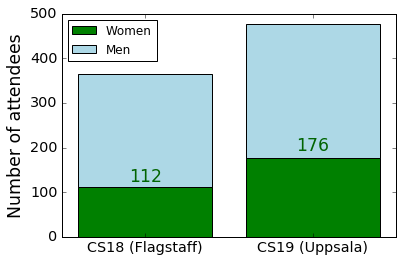

In [56]:
compare_counts([women18,women19], [men18,men19], [attendees18,attendees19])
ax = plt.gca()
ax.set_ylabel("Number of attendees",fontsize="xx-large")
plt.savefig("attendees.eps",bbox_inches="tight")

[ 0.03  0.03]


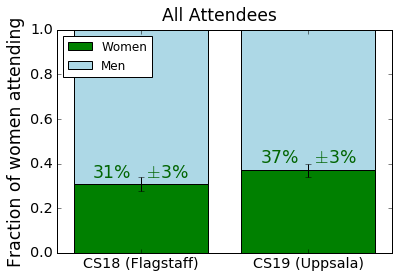

In [57]:
compare_women_fractions(np.array([women18,women19]), np.array([men18,men19]), 
                        np.array([attendees18,attendees19]),
                        percent_uncertainties=np.array([0.03,0.03]))
plt.suptitle("All Attendees",fontsize="xx-large")
plt.ylabel("Fraction of women attending",fontsize="xx-large")
plt.savefig("attendees_percentages.eps",bbox_inches="tight")

### Fraction of women asking questions

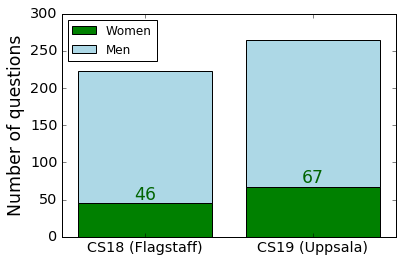

In [16]:
compare_counts(women_count, men_count, totals_conference)
ax = plt.gca()
ax.set_ylabel("Number of questions",fontsize="xx-large")
plt.savefig("raw_questions.eps",bbox_inches="tight")

[ 0.05310854  0.05249533]


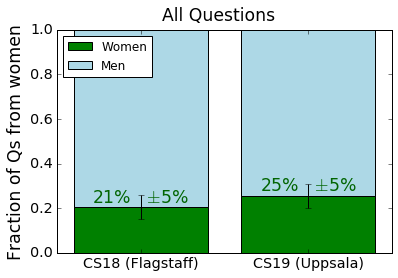

In [17]:
compare_women_fractions(women_count, men_count, totals_conference)
plt.suptitle("All Questions",fontsize="xx-large")
plt.savefig("raw_percentages.eps",bbox_inches="tight")

This is consistent with Jim's 2014 paper. He found that women asked 24.1% of questions at AAS223, where 34.7% of talks were given by women.

### What are the raw numbers and percentages of men and women giving talks?

[ 0.10921533  0.10579775]


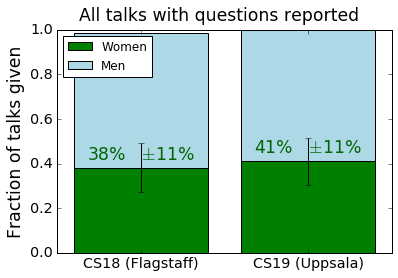

In [18]:
women_talks = np.array([len(np.where(cs18["Speaker Gender"]=="F")[0]),
                        len(np.where(cs19["Speaker Gender"]=="F")[0])])
men_talks = np.array([len(np.where(cs18["Speaker Gender"]=="M")[0]),
                        len(np.where(cs19["Speaker Gender"]=="M")[0])])
total_talks = np.array([len(cs18),len(cs19)])

compare_women_fractions(women_talks, men_talks, total_talks)
ax = plt.gca()
ax.set_ylabel("Fraction of talks given",fontsize="xx-large")
plt.suptitle("All talks with questions reported",fontsize="xx-large")
plt.savefig("talk_percentages.eps",bbox_inches="tight")

At least in terms of reported talks, the fraction of women giving talks matches (and slightly exceeds) the fraction of women in attendance. 

(I'm not sure why the CS18 fractions don't add up...)

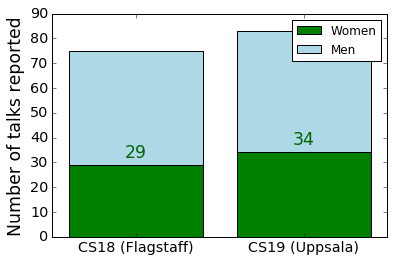

In [19]:
compare_counts(women_talks, men_talks, total_talks)
ax = plt.gca()
ax.set_ylabel("Number of talks reported",fontsize="xx-large")
plt.savefig("raw_talks_reported.eps",bbox_inches="tight")

## What is the effect of a speaker's gender on the number of questions asked them?

3.41379310345 2.60869565217


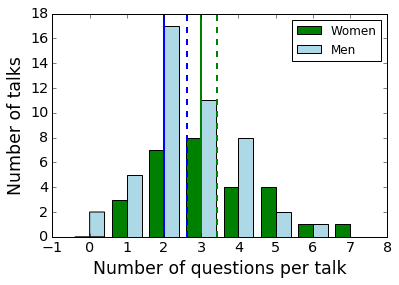

In [50]:
cs18_set = [cs18_count[:,2][cs18["Speaker Gender"]=="F"],
          cs18_count[:,2][cs18["Speaker Gender"]=="M"]]
plt.hist(cs18_set,
         color=["Green","LightBlue"],bins=np.arange(9),histtype="bar",
         align="left",label=["Women","Men"])
ax = plt.gca()
ax.legend(loc=1)
ax.axvline(np.median(cs18_set[0]),color="Green",linestyle="-",lw="2")
ax.axvline(np.median(cs18_set[1]),color="Blue",linestyle="-",lw="2")
print(np.mean(cs18_set[0]),np.mean(cs18_set[1]))
ax.axvline(np.mean(cs18_set[0]),color="Green",linestyle="--",lw="2")
ax.axvline(np.mean(cs18_set[1]),color="Blue",linestyle="--",lw="2")
ax.set_xlabel("Number of questions per talk",fontsize="xx-large")
ax.set_ylabel("Number of talks",fontsize="xx-large")
ax.tick_params(labelsize="x-large")

3.20588235294 3.16326530612


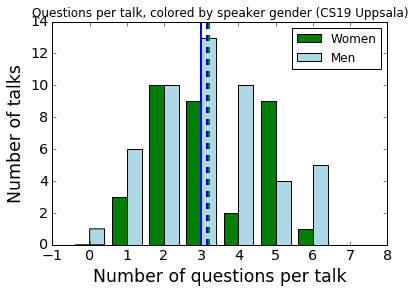

In [51]:
cs19_set = [cs19_count[:,2][cs19["Speaker Gender"]=="F"],
          cs19_count[:,2][cs19["Speaker Gender"]=="M"]]
plt.hist(cs19_set,
         color=["Green","LightBlue"],bins=np.arange(9),histtype="bar",
         align="left",label=["Women","Men"])
ax = plt.gca()
ax.legend(loc=1)
ax.set_title("Questions per talk, colored by speaker gender (CS19 Uppsala)")
ax.axvline(np.median(cs19_set[0]),color="Green",linestyle="-",lw="2")
ax.axvline(np.median(cs19_set[1]),color="Blue",linestyle="-",lw="2")
print(np.mean(cs19_set[0]),np.mean(cs19_set[1]))
ax.axvline(np.mean(cs19_set[0]),color="Green",linestyle="--",lw="2")
ax.axvline(np.mean(cs19_set[1]),color="Blue",linestyle="--",lw="2")
ax.set_xlabel("Number of questions per talk",fontsize="xx-large")
ax.set_ylabel("Number of talks",fontsize="xx-large")
ax.tick_params(labelsize="x-large")

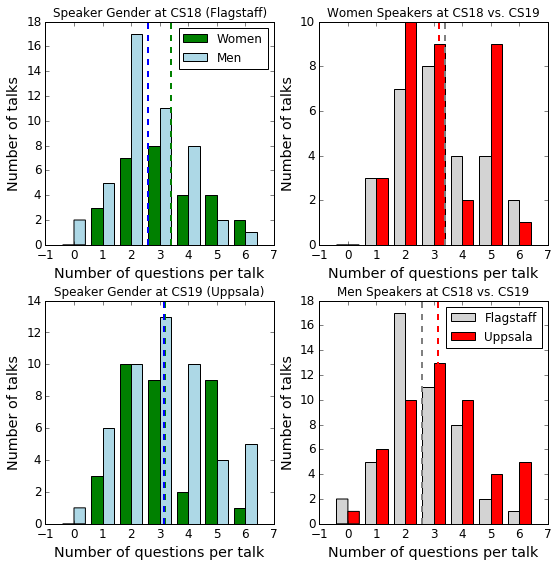

In [22]:
plt.figure(figsize=(9,9))

# Plot CS18 distribution colored by gender
ax1 = plt.subplot(221)
ax1.hist(cs18_set,
         color=["Green","LightBlue"],bins=np.arange(8),histtype="bar",
         align="left",label=["Women","Men"])
ax1.legend(loc=1)

ax1.axvline(np.mean(cs18_set[0]),color="Green",linestyle="--",lw="2")
ax1.axvline(np.mean(cs18_set[1]),color="Blue",linestyle="--",lw="2")
ax1.set_xlabel("Number of questions per talk",fontsize="x-large")
ax1.set_ylabel("Number of talks",fontsize="x-large")
ax1.tick_params(labelsize="large")

ax1.set_title("Speaker Gender at CS18 (Flagstaff)")

# Plot CS19 distribution colored by gender
ax2 = plt.subplot(223, sharex=ax1)

ax2.hist(cs19_set,
         color=["Green","LightBlue"],bins=np.arange(8),histtype="bar",
         align="left",label=["Women","Men"])
ax2.axvline(np.mean(cs19_set[0]),color="Green",linestyle="--",lw="2")
ax2.axvline(np.mean(cs19_set[1]),color="Blue",linestyle="--",lw="2")
ax2.set_xlabel(ax1.get_xlabel(),fontsize="x-large")
ax2.set_ylabel(ax1.get_ylabel(),fontsize="x-large")
ax2.set_title("Speaker Gender at CS19 (Uppsala)")
ax2.tick_params(labelsize="large")

# Plot Women, colored by conference
ax3 = plt.subplot(222, sharex=ax1)
women_set = [cs18_set[0], cs19_set[0]]
ax3.hist(women_set,
         color=["LightGrey","Red"],bins=np.arange(8),histtype="bar",
         align="left",label=["Flagstaff","Uppsala"])
ax3.axvline(np.mean(women_set[0]),color="Grey",linestyle="--",lw="2")
ax3.axvline(np.mean(women_set[1]),color="Red",linestyle="--",lw="2")
ax3.set_xlabel(ax1.get_xlabel(),fontsize="x-large")
ax3.set_ylabel(ax1.get_ylabel(),fontsize="x-large")
ax3.set_title("Women Speakers at CS18 vs. CS19")
ax3.tick_params(labelsize="large")


# Plot men, colored by conference
ax4 = plt.subplot(224, sharex=ax1)
men_set = [cs18_set[1], cs19_set[1]]
ax4.hist(men_set,
         color=["LightGrey","Red"],bins=np.arange(8),histtype="bar",
         align="left",label=["Flagstaff","Uppsala"])
ax4.axvline(np.mean(men_set[0]),color="Grey",linestyle="--",lw="2")
ax4.axvline(np.mean(men_set[1]),color="Red",linestyle="--",lw="2")
ax4.set_xlabel(ax1.get_xlabel(),fontsize="x-large")
ax4.set_ylabel(ax1.get_ylabel(),fontsize="x-large")
ax4.legend(loc=1)
ax4.set_title("Men Speakers at CS18 vs. CS19")
ax4.tick_params(labelsize="large")

plt.subplots_adjust(hspace=0.25)

plt.savefig("speaker_gender.eps",bbox_inches="tight")

# Set up a consistent plot format

In [23]:
def triple_panel(sets, labels, qcount, plot_labels, colors):
    """Calculate statistics and plot a three-panel plot showing 
    1) Raw number of talks included
    2) Mean number of questions/talk
    3) Fraction of questions asked by women
    """
    
    # Calculate statistics
    set_means = np.zeros(4)
    set_stds = np.zeros(4)
    for i,s,l in itertools.izip(np.arange(4),sets,labels):
        set_means[i] = np.mean(qcount[:,2][s])
        set_stds[i] = np.std(qcount[:,2][s])
        print("On average, there were {0:.1f} questions with a {1}".format(set_means[i],l))

    print(" ")

    set_women = np.zeros(4)
    set_totals = np.zeros(4)
    for i,s,l in itertools.izip(np.arange(4),sets,labels):
        set_women[i] = np.sum(qcount[:,1][s])
        set_totals[i] = np.sum(qcount[:,2][s])
        print("{0:.0f} of {1:.0f} questions were asked by women with a {2}".format(set_women[i],
                                                                           set_totals[i],l))
    set_percentages = set_women / set_totals
    set_uncertainties = binom_unc(set_percentages, set_totals)
    print(set_uncertainties)
    
    raw_counts = np.array([len(np.where(s)[0]) for s in sets])
    
    # Plot
    fig = plt.figure(figsize=(8,14))

    x = np.array([1,2,3.5,4.5])
    xticklabels = plot_labels#np.array(["FS, Inv","MS, Inv","FS, Con","MS, Con"]) 

    # Raw # of talks
    ax = plt.subplot(311)
    y = raw_counts

    for i in range(4):
        ax.bar(x[i],y[i],width=1,color=colors[i],align="center")

    ax.set_xticks(x)
    ax.set_xticklabels(plot_labels)
    ax.set_ylabel("Number of talks reported",fontsize="xx-large")
    ax.tick_params(labelsize="x-large")

    # Average number of questions per talk
    y = set_means
    ax = plt.subplot(312)
    for i in range(4):
        ax.bar(x[i],y[i],width=1,color=colors[i],align="center")

    ax.set_xticks(x)
    ax.set_xticklabels(plot_labels)
    ax.set_ylabel("Mean questions per talk",fontsize="xx-large")
    ax.tick_params(labelsize="x-large")

    # Fraction asked by Women
    y = set_percentages
    ax = plt.subplot(313)
    for i in range(4):
        ax.bar(x[i],y[i],width=1,color=colors[i],align="center")

    ax.errorbar(x,set_percentages,set_uncertainties,color="k",
                ecolor="k",fmt="",lw=0,elinewidth=1)

    ax.set_xticks(x)
    ax.set_xticklabels(plot_labels)
    ax.set_ylabel("Fraction of Qs Asked by Women",fontsize="xx-large")
    ax.tick_params(labelsize="x-large")
    ax.set_ylim(ymin=0)

## What is the effect of chair gender on the number of questions allowed?

In [24]:
cs19_chairs = [cs19_count[:,2][cs19["Chair Gender"]=="F"],
          cs19_count[:,2][cs19["Chair Gender"]=="M"]]

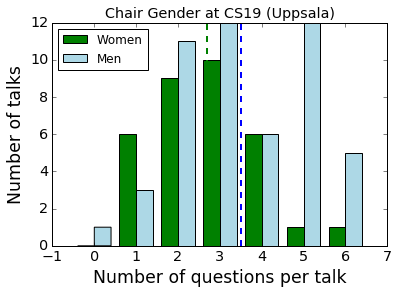

In [25]:
plt.figure()

# Plot CS18 distribution colored by gender
ax1 = plt.subplot(111)
ax1.hist(cs19_chairs,
         color=["Green","LightBlue"],bins=np.arange(8),histtype="bar",
         align="left",label=["Women","Men"])
ax1.legend(loc=2)

ax1.axvline(np.mean(cs19_chairs[0]),color="Green",linestyle="--",lw="2")
ax1.axvline(np.mean(cs19_chairs[1]),color="Blue",linestyle="--",lw="2")
ax1.set_xlabel("Number of questions per talk",fontsize="xx-large")
ax1.set_ylabel("Number of talks",fontsize="xx-large")
ax1.tick_params(labelsize="x-large")

ax1.set_title("Chair Gender at CS19 (Uppsala)",fontsize="x-large")

plt.savefig("chair_gender_num_questions.eps",bbox_inches="tight")

Both the plot above and the three-paneled one below show the same thing: when chairing a session, men allow on average one more question than women. 

AH - all the plenary chairs were men (sigh), where there was usually more space for questions.

2.69696969697 2.4


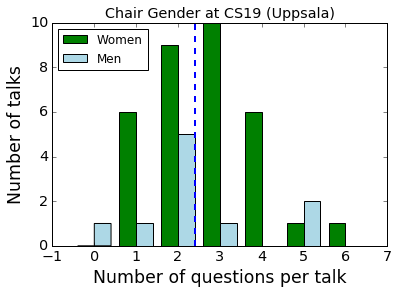

In [26]:
splinter = cs19["Session Type"]=="Splinter"
plt.figure()

cs19_splinter_chairs = [cs19_count[:,2][(cs19["Chair Gender"]=="F") & splinter],
          cs19_count[:,2][(cs19["Chair Gender"]=="M") & splinter]]

# Plot CS18 distribution colored by gender
ax1 = plt.subplot(111)
ax1.hist(cs19_splinter_chairs,
         color=["Green","LightBlue"],bins=np.arange(8),histtype="bar",
         align="left",label=["Women","Men"])
ax1.legend(loc=2)

ax1.axvline(np.mean(cs19_splinter_chairs[0]),color="Green",linestyle="--",lw="2")
ax1.axvline(np.mean(cs19_splinter_chairs[1]),color="Blue",linestyle="--",lw="2")
print(np.mean(cs19_splinter_chairs[0]),np.mean(cs19_splinter_chairs[1]))
ax1.set_xlabel("Number of questions per talk",fontsize="xx-large")
ax1.set_ylabel("Number of talks",fontsize="xx-large")
ax1.tick_params(labelsize="x-large")

ax1.set_title("Chair Gender at CS19 (Uppsala)",fontsize="x-large")

# plt.savefig("chair_gender_num_questions_splintersonly.eps",
#             bbox_inches="tight")

Yes, when comparing splinters to splinters (despite the session-to-session variability in question time allowed), the mean number of questions allowed by male chairs drops.

In [27]:
# Plot combinations of male/female chair+speaker

fspeaker = cs19["Speaker Gender"]=="F"
fchair = cs19["Chair Gender"]=="F"

mspeaker = cs19["Speaker Gender"]=="M"
mchair = cs19["Chair Gender"]=="M"

ffcount = len(np.where(fspeaker & fchair)[0])
fmcount = len(np.where(fchair & mspeaker)[0])

mmcount = len(np.where(mchair & mspeaker)[0])
mfcount = len(np.where(mchair & fspeaker)[0])

On average, there were 2.6 questions with a Female Chair and Female Speaker
On average, there were 2.8 questions with a Female Chair and Male Speaker
On average, there were 3.6 questions with a Male Chair and Female Speaker
On average, there were 3.4 questions with a Male Chair and Male Speaker
 
6 of 23 questions were asked by women with a Female Chair and Female Speaker
18 of 66 questions were asked by women with a Female Chair and Male Speaker
25 of 89 questions were asked by women with a Male Chair and Female Speaker
18 of 86 questions were asked by women with a Male Chair and Male Speaker
[ 0.17945865  0.10744768  0.09337509  0.08598033]


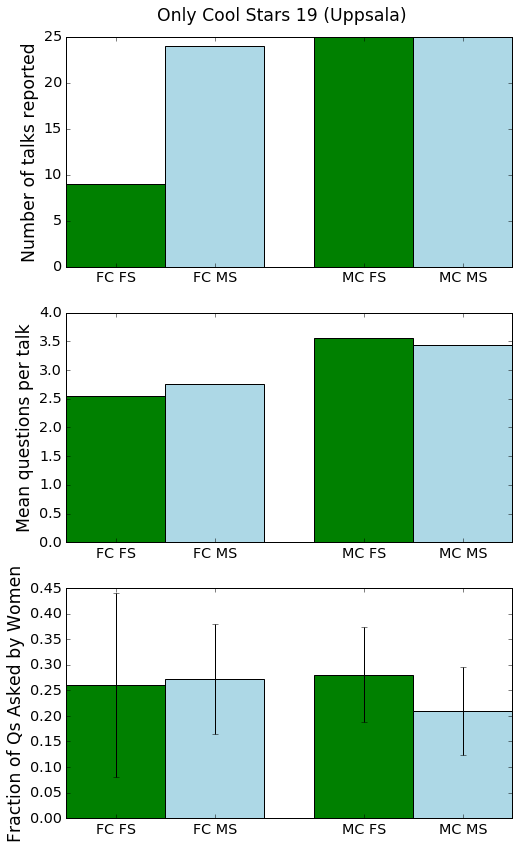

In [28]:
sets = [(fspeaker & fchair), (fchair & mspeaker),
        (mchair & mspeaker), (mchair & fspeaker)]
labels = ["Female Chair and Female Speaker",
          "Female Chair and Male Speaker",
          "Male Chair and Female Speaker",
          "Male Chair and Male Speaker"]
plotlabels = np.array(["FC FS","FC MS","MC FS","MC MS"]) 
colors = np.array(["Green","LightBlue","Green","LightBlue"])
triple_panel(sets,labels,cs19_count,plotlabels,colors)
plt.suptitle("Only Cool Stars 19 (Uppsala)",fontsize="xx-large",y=0.93)

plt.savefig("chair_gender.eps",bbox_inches="tight")

## What is the impact of chair gender on the fraction of questions from women?

[24 43] [ 65 132] [ 89 175]
[ 0.09220052  0.06378524]


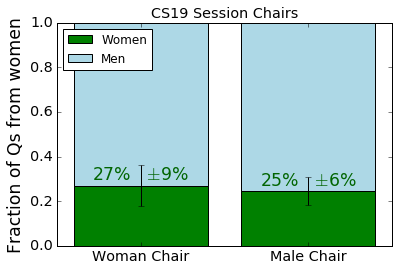

In [29]:
women_count = np.array([np.sum(cs19_count[:,1][fchair]),np.sum(cs19_count[:,1][mchair])])
men_count = np.array([np.sum(cs19_count[:,0][fchair]),np.sum(cs19_count[:,0][mchair])])
totals_conference = np.array([np.sum(cs19_count[:,2][fchair]),np.sum(cs19_count[:,2][mchair])])
print(women_count, men_count, totals_conference)

compare_women_fractions(women_count, men_count, totals_conference,
                           colors=["Green","LightBlue"],
                           xlabels=["Woman Chair","Male Chair"])
ax = plt.gca()
ax.set_title("CS19 Session Chairs",fontsize="x-large")

So chair gender has no impact on the fraction of questions asked by women. This is NOT consistent with Jim's 2014 paper, where he found that the fraction of women asking questions dropped from 34% with a woman as chair to just 20% with a man as chair. Instead, we find percentages that are in the middle of those, independent of chair gender.

Why is there such a discrepancy from AAS to Cool Stars?
- Are there more women at CS? No - according to Jim's paper, 34% of AAS 223 participants (giving any sort of presentation) were women
- Could meeting size have an impact? A smaller meeting where more people know each other (and the talks are of a slightly more substantive length) could encourage more women to ask questions. I think Cool Stars is the only small conference Jim has data for, so we'd need to get someone else to take this data at another small conference. 
- On the other hand, the AAS sessions are organized by subfield, so in theory people should know each other there too. 
- Have the AAS numbers changed in the last two meetings?


[24  6] [65 18] [89 24]
[ 0.09220052  0.17324116]


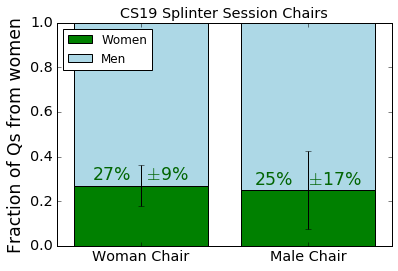

In [30]:
splinter = cs19["Session Type"]=="Splinter"

women_count = np.array([np.sum(cs19_count[:,1][fchair & splinter]),
                        np.sum(cs19_count[:,1][mchair & splinter])])
men_count = np.array([np.sum(cs19_count[:,0][fchair & splinter]),
                      np.sum(cs19_count[:,0][mchair & splinter])])
totals_conference = np.array([np.sum(cs19_count[:,2][fchair & splinter]),
                              np.sum(cs19_count[:,2][mchair & splinter])])
print(women_count, men_count, totals_conference)

compare_women_fractions(women_count, men_count, totals_conference,
                           colors=["Green","LightBlue"],
                           xlabels=["Woman Chair","Male Chair"])
ax = plt.gca()
ax.set_title("CS19 Splinter Session Chairs",fontsize="x-large")

[ 0 37] [  0 114] [  1 151]
[ 0.          0.06860313]


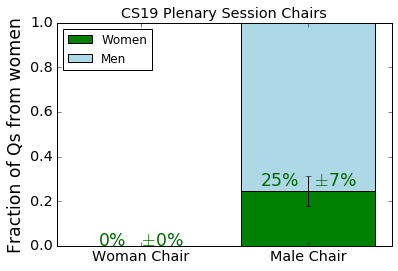

In [31]:
plenary = cs19["Session Type"]=="Plenary"

women_count = np.array([np.sum(cs19_count[:,1][fchair & plenary]),
                        np.sum(cs19_count[:,1][mchair & plenary])])
men_count = np.array([np.sum(cs19_count[:,0][fchair & plenary]),
                      np.sum(cs19_count[:,0][mchair & plenary])])
totals_conference = np.array([1,
                              np.sum(cs19_count[:,2][mchair & plenary])])
print(women_count, men_count, totals_conference)

compare_women_fractions(women_count, men_count, totals_conference,
                           colors=["Green","LightBlue"],
                           xlabels=["Woman Chair","Male Chair"])
ax = plt.gca()
ax.set_title("CS19 Plenary Session Chairs",fontsize="x-large")

We don't have chair gender data for CS18, and it's not listed in the online or pdf schedule, so I can't pull it from there either

## Is there any difference in how many questions are addressed to invited vs. contributed talks?

### Invited vs. Contributed: Just CS18

In [32]:
fspeaker = cs18["Speaker Gender"]=="F"
mspeaker = cs18["Speaker Gender"]=="M"

invited = (cs18["Speaker Type"]=="Invited") | (cs18["Speaker Type"]=="Review")
contrib = cs18["Speaker Type"]=="Contributed"

finv = fspeaker & invited
minv = mspeaker & invited

fcon = fspeaker & contrib
mcon = mspeaker & contrib

On average, there were 3.2 questions with a Female Speaker, Invited
On average, there were 2.8 questions with a Male Speaker, Invited
On average, there were 3.5 questions with a Female Speaker, Contributed
On average, there were 2.5 questions with a Male Speaker, Contributed
 
7 of 29 questions were asked by women with a Female Speaker, Invited
13 of 61 questions were asked by women with a Male Speaker, Invited
12 of 70 questions were asked by women with a Female Speaker, Contributed
12 of 55 questions were asked by women with a Male Speaker, Contributed
[ 0.15574691  0.10276698  0.08829043  0.1091533 ]


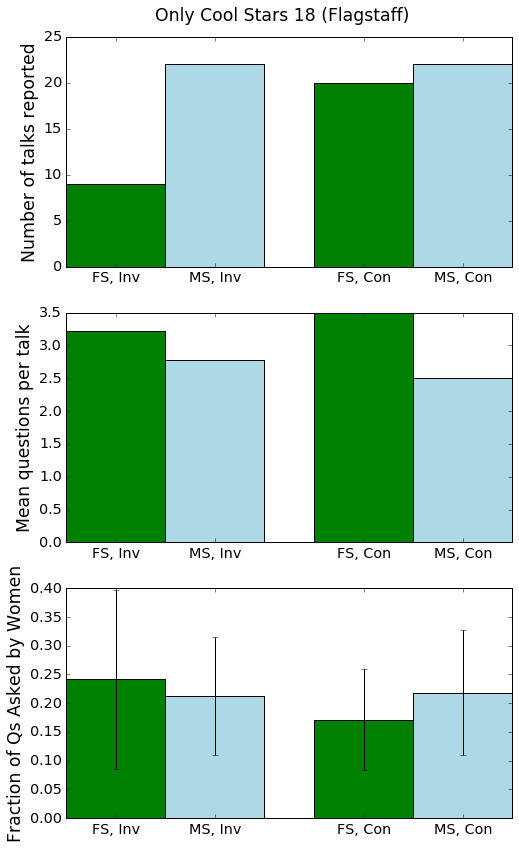

In [33]:
sets = [finv, minv, fcon, mcon]
labels = ["Female Speaker, Invited",
          "Male Speaker, Invited",
          "Female Speaker, Contributed",
          "Male Speaker, Contributed"]
plotlabels = np.array(["FS, Inv","MS, Inv","FS, Con","MS, Con"]) 
colors = np.array(["Green","LightBlue","Green","LightBlue"])
triple_panel(sets,labels,cs18_count,plotlabels,colors)
plt.suptitle("Only Cool Stars 18 (Flagstaff)",fontsize="xx-large",y=0.93)
plt.savefig("invited_contrib_cs18.eps",bbox_inches="tight")

### Invited vs. Contributed: Just CS19

In [34]:
fspeaker = cs19["Speaker Gender"]=="F"
mspeaker = cs19["Speaker Gender"]=="M"

invited = (cs19["Speaker Type"]=="invited") | (cs19["Speaker Type"]=="Review")
contrib = cs19["Speaker Type"]=="contributed"

finv = fspeaker & invited
minv = mspeaker & invited

fcon = fspeaker & contrib
mcon = mspeaker & contrib

On average, there were 3.6 questions with a Female Speaker, Invited
On average, there were 3.3 questions with a Male Speaker, Invited
On average, there were 3.0 questions with a Female Speaker, Contributed
On average, there were 3.1 questions with a Male Speaker, Contributed
 
10 of 36 questions were asked by women with a Female Speaker, Invited
8 of 43 questions were asked by women with a Male Speaker, Invited
14 of 73 questions were asked by women with a Female Speaker, Contributed
35 of 112 questions were asked by women with a Male Speaker, Contributed
[ 0.14631505  0.11631411  0.0903154   0.0858437 ]


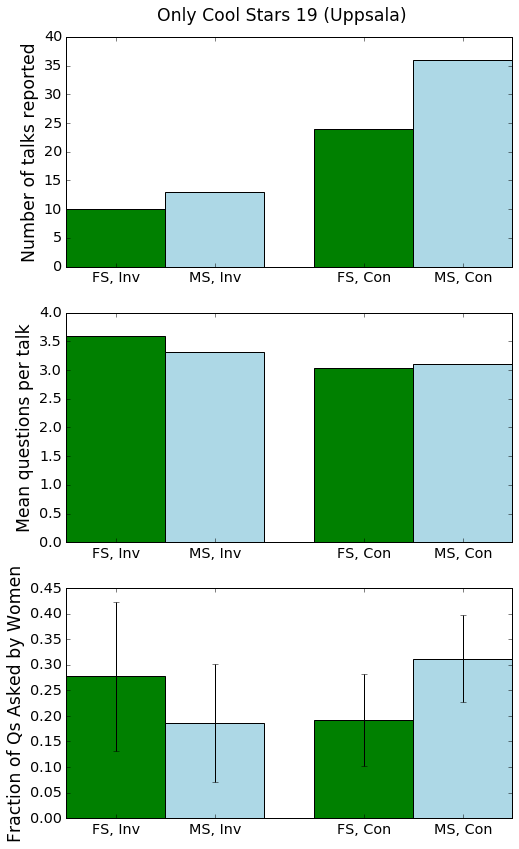

In [35]:
sets = [finv, minv, fcon, mcon]
labels = ["Female Speaker, Invited",
          "Male Speaker, Invited",
          "Female Speaker, Contributed",
          "Male Speaker, Contributed"]
plotlabels = np.array(["FS, Inv","MS, Inv","FS, Con","MS, Con"]) 
colors = np.array(["Green","LightBlue","Green","LightBlue"])
triple_panel(sets,labels,cs19_count,plotlabels,colors)
plt.suptitle("Only Cool Stars 19 (Uppsala)",fontsize="xx-large",y=0.93)
plt.savefig("invited_contrib_cs19.eps",bbox_inches="tight")

What about just plenaries? 

On average, there were 4.4 questions with a Female Speaker, Invited
On average, there were 5.3 questions with a Male Speaker, Invited
On average, there were 3.2 questions with a Female Speaker, Contributed
On average, there were 3.6 questions with a Male Speaker, Contributed
 
9 of 31 questions were asked by women with a Female Speaker, Invited
5 of 16 questions were asked by women with a Male Speaker, Invited
4 of 42 questions were asked by women with a Female Speaker, Contributed
19 of 62 questions were asked by women with a Male Speaker, Contributed
[ 0.15978872  0.22712108  0.08877771  0.1147571 ]


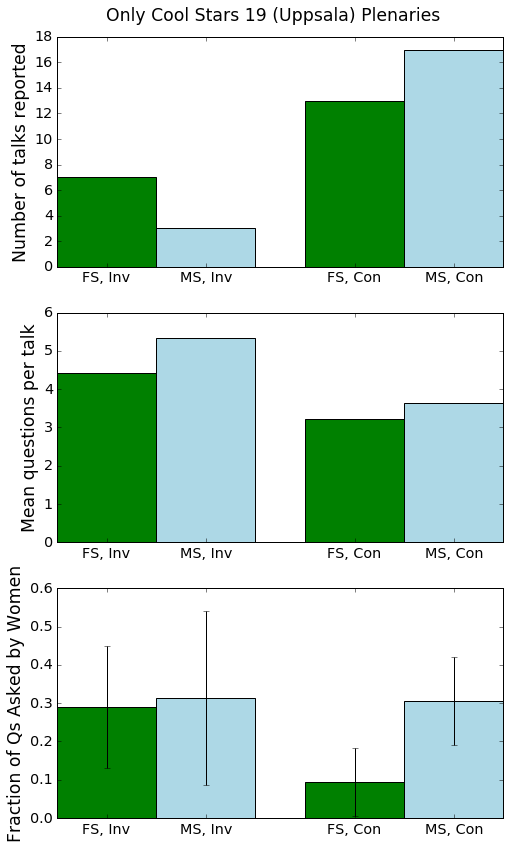

In [36]:
plenary = cs19["Session Type"]=="Plenary"
sets = [finv & plenary, minv & plenary, fcon & plenary, mcon & plenary]
labels = ["Female Speaker, Invited",
          "Male Speaker, Invited",
          "Female Speaker, Contributed",
          "Male Speaker, Contributed"]
plotlabels = np.array(["FS, Inv","MS, Inv","FS, Con","MS, Con"]) 
colors = np.array(["Green","LightBlue","Green","LightBlue"])
triple_panel(sets,labels,cs19_count,plotlabels,colors)
plt.suptitle("Only Cool Stars 19 (Uppsala) Plenaries",fontsize="xx-large",y=0.93)
plt.savefig("invited_contrib_cs19_plenary.eps",bbox_inches="tight")

### Invited vs. Contributed: Combined Sample

In [37]:
fspeaker = combined["Speaker Gender"]=="F"
mspeaker = combined["Speaker Gender"]=="M"

invited = ((combined["Speaker Type"]=="invited") | (combined["Speaker Type"]=="Review") 
           | (combined["Speaker Type"]=="Invited"))
contrib = (combined["Speaker Type"]=="contributed") | (combined["Speaker Type"]=="Contributed")

finv = fspeaker & invited
minv = mspeaker & invited

fcon = fspeaker & contrib
mcon = mspeaker & contrib

On average, there were 3.4 questions with a Female Speaker, Invited
On average, there were 3.0 questions with a Male Speaker, Invited
On average, there were 3.2 questions with a Female Speaker, Contributed
On average, there were 2.9 questions with a Male Speaker, Contributed
 
17 of 65 questions were asked by women with a Female Speaker, Invited
21 of 104 questions were asked by women with a Male Speaker, Invited
26 of 143 questions were asked by women with a Female Speaker, Contributed
47 of 167 questions were asked by women with a Male Speaker, Contributed
[ 0.10683932  0.07715334  0.06321667  0.06820574]


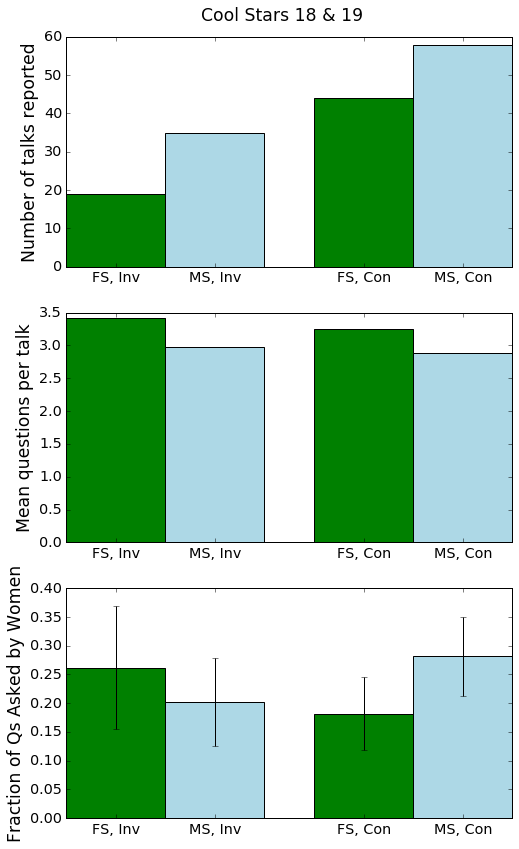

In [38]:
sets = [finv, minv, fcon, mcon]
labels = ["Female Speaker, Invited",
          "Male Speaker, Invited",
          "Female Speaker, Contributed",
          "Male Speaker, Contributed"]
plotlabels = np.array(["FS, Inv","MS, Inv","FS, Con","MS, Con"]) 
colors = np.array(["Green","LightBlue","Green","LightBlue"])
triple_panel(sets,labels,combined_count,plotlabels,colors)
plt.suptitle("Cool Stars 18 & 19",fontsize="xx-large",y=0.93)
plt.savefig("invited_contrib_combined.eps",bbox_inches="tight")

# Just compare plenary sessions

In [39]:
cs18_plenary = cs18[cs18["Session Type"]=="Plenary"]
cs19_plenary = cs19[cs19["Session Type"]=="Plenary"]

cs18_pq, cs18_pcount = split_questions(cs18_plenary["Questions"],9)
cs19_pq, cs19_pcount = split_questions(cs19_plenary["Questions"],10)

cs18_pflat = cs18_pq.flatten()
cs19_pflat = cs19_pq.flatten()

In [40]:
y_18 = np.array([len(np.where(cs18_pflat=="M")[0]),
        len(np.where(cs18_pflat=="F")[0])])
y_19 = np.array([len(np.where(cs19_pflat=="M")[0]),
        len(np.where(cs19_pflat=="F")[0])])
totals_conference = np.array([np.sum(y_18),np.sum(y_19)])

men_count = np.array([y_18[0],y_19[0]])
women_count = np.array([y_18[1],y_19[1]])

print("CS 18 (Flagstaff) had {0} men and {1} women ask questions in plenaries "
      "({2} total questions)".format(y_18[0],y_18[1],totals_conference[0]))
print("CS 19 (Uppsala) had {0} men and {1} women ask questions in plenaries "
      "({2} total questions)".format(y_19[0],y_19[1],totals_conference[1]))

CS 18 (Flagstaff) had 65 men and 22 women ask questions in plenaries (87 total questions)
CS 19 (Uppsala) had 114 men and 37 women ask questions in plenaries (151 total questions)


[ 0.09133668  0.06860313]


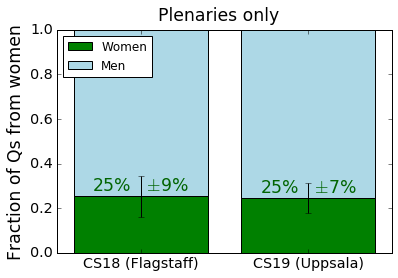

In [41]:
compare_women_fractions(women_count, men_count, totals_conference)
plt.suptitle("Plenaries only",fontsize="xx-large")
plt.savefig("plenaries_fraction.eps",bbox_inches="tight")

# Where in the order do women usually ask questions?

In [42]:
def plot_order(questions,colors=["Green","Blue"],
               conference_mean=0.25,):
    x = np.arange(9)

    fcount = np.array([len(np.where(questions[:,i]=="F")[0]) for i in x])
    mcount = np.array([len(np.where(questions[:,i]=="M")[0]) for i in x])

    fcumulative = np.array([np.sum(fcount[:i+1]) for i in x])
    mcumulative = np.array([np.sum(mcount[:i+1]) for i in x])

    total_count = fcount + mcount
    fraction = fcount / total_count
    fraction[np.isfinite(fraction)==False] = 0
    fraction_uncertainties = binom_unc(fraction, total_count)
    print(fraction_uncertainties)

    cumulative_total = np.array([np.sum(total_count[:i+1]) for i in x])
    cumulative_fraction = fcumulative / cumulative_total

    # Distribution of number of questions asked
    plt.figure()
    ax = plt.subplot(111)
    ax.bar(x+0.8,fcount,width=0.4,color=colors[0],align="center")
    ax.bar(x+1.2,mcount,width=0.4,color=colors[1],align="center")
    ax.set_xlabel("Question number",fontsize="xx-large")
    ax.set_ylabel("Number of questioners",fontsize="xx-large")
    ax.tick_params(labelsize="x-large")
    ax.set_xlim(0,9)
    
    # Normalized distributions by gender
    plt.figure()
    ax = plt.subplot(111)
    ax.step(x+1,fcount/max(fcount),color=colors[0],where="mid",lw=2)
    ax.step(x+1,mcount/max(mcount),color=colors[1],where="mid",linestyle="--",lw=2)
    ax.set_xlabel("Question number",fontsize="xx-large")
    ax.set_ylabel("Normalized distribution",fontsize="xx-large")
    ax.tick_params(labelsize="x-large")
    ax.set_ylim(0,1.05)
    ax.set_xlim(0.95,8)
    
    # Evolving fraction of women asking questions
    plt.figure()
    ax = plt.subplot(111)
    ax.step(x+1,fraction,color=colors[0],where="mid",lw=2,label="Just that position")
    ax.errorbar(x+1,fraction,fraction_uncertainties,color="g",ecolor="g",lw=0,elinewidth=1)
    ax.step(x+1,cumulative_fraction,color="DarkGreen",where="mid",linestyle="--",lw=2,
           label="Cumulative fraction")
    ax.axhline(conference_mean,color='k',ls=':',lw=2,label="Conference Mean")
    ax.set_xlabel("Question number",fontsize="xx-large")
    ax.set_ylabel("Fraction of Qs asked by women",fontsize="xx-large")
    ax.tick_params(labelsize="x-large")
    ax.legend(loc="best")
    #ax.set_ylim(0,0.5)
    ax.set_xlim(0.95,8)

### Question Order at CS19

[ 0.08577629  0.10065734  0.12750069  0.16455958  0.13799556  0.37720218
         nan         nan         nan]


/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide
/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from IPython.kernel.zmq import kernelapp as app


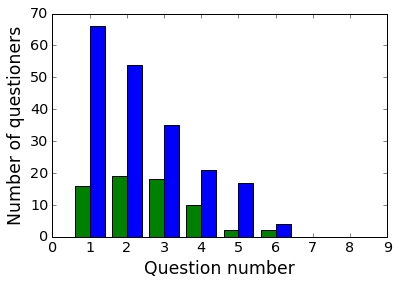

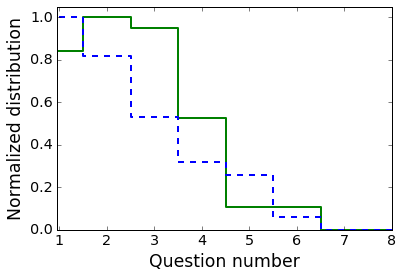

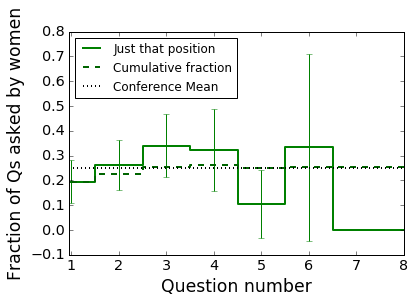

In [43]:
plot_order(cs19_q,conference_mean=0.25)

The distribution of male question askers peaks at Q1, amd steadily declines from there, while for women it peaks at 2 and 3 and drops off sharply after that. 

Getting to the conference mean fraction of questions asked by women means allowing at least 3 questions, though there's a slight increase at 4. After that, though, the fraction holds steady. 

The peak fraction of women asking questions is at the 3rd and 6th questions.

(What is that dip and bump at 5 and 6?)

### Question Order at CS18

[ 0.0937956   0.0865036   0.11875902  0.18805     0.18594193  0.49
  0.69296465  0.          0.        ]


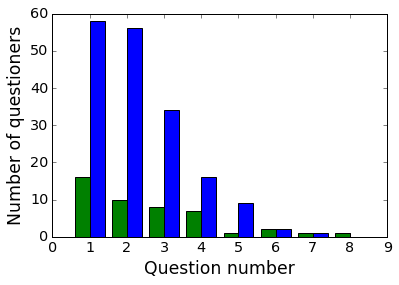

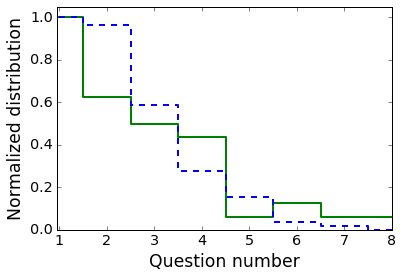

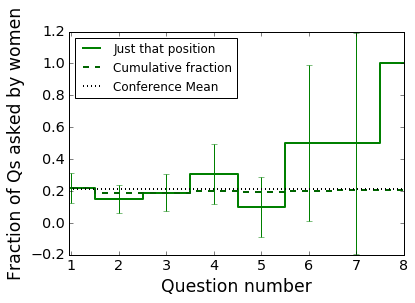

In [44]:
plot_order(cs18_q,conference_mean=0.21)

So at CS18, there's no strong dependence on question position until question SIX, and then our numbers are small

Let's look at this a different way.

## What is the fraction of women asking questions as a function of the total number of questions allowed?

In [45]:
def plot_fraction_allowed(qcount,colors=["Green","Blue"],
               conference_mean=0.25,):

    n_talks = len(qcount)
    fraction_women = qcount[:,1] / qcount[:,2]
    max_qs = max(qcount[:,2])+1
    x = np.arange(max_qs)
    
    fcount = np.zeros(max_qs)
    mcount = np.zeros(max_qs)
    total_count = np.zeros(max_qs)
    for nquestions in x:
        iloc = qcount[:,2]==nquestions
#        print(nquestions,len(np.where(iloc)[0]))
#        print(qcount[:,1][iloc])
        
        fcount[nquestions] = sum(qcount[:,1][iloc])
        mcount[nquestions] = sum(qcount[:,0][iloc])
        total_count[nquestions] = sum(qcount[:,2][iloc])

#    print(fcount)    
    fraction = fcount / total_count
    fraction[np.isfinite(fraction)==False] = 0
#    fraction_uncertainties = binom_unc(fraction, total_count)
#    print(fraction_uncertainties)

    # Distribution of number of questions asked
    plt.figure()
    ax = plt.subplot(111)
    ax.bar(x-0.2,fcount,width=0.4,color=colors[0],align="center")
    ax.bar(x+0.2,mcount,width=0.4,color=colors[1],align="center")
    ax.set_xlabel("Number of questions allowed",fontsize="xx-large")
    ax.set_ylabel("Number of questioners",fontsize="xx-large")
    ax.tick_params(labelsize="x-large")
    #ax.set_xlim(0,max_qs)
    
    # Evolving fraction of women asking questions
    plt.figure()
    ax = plt.subplot(111,sharex=ax)
    ax.step(x,fraction,color=colors[0],where="mid",lw=2,label="Raw fraction")
#    ax.errorbar(x,fraction,fraction_uncertainties,color="g",ecolor="g",lw=0,elinewidth=1)
    ax.axhline(conference_mean,color='k',ls=':',lw=2,label="Conference Mean")
    ax.set_xlabel("Number of questions allowed",fontsize="xx-large")
    ax.set_ylabel("Fraction of Qs asked by women",fontsize="xx-large")
    ax.tick_params(labelsize="x-large")
    ax.legend(loc="best")
    #ax.set_ylim(0,0.5)
    ax.set_xlim(0,max_qs)


/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide


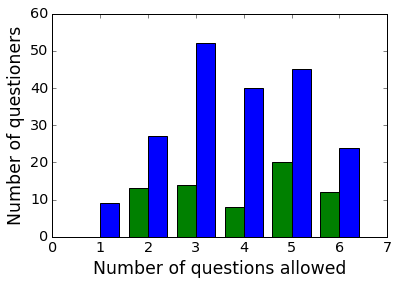

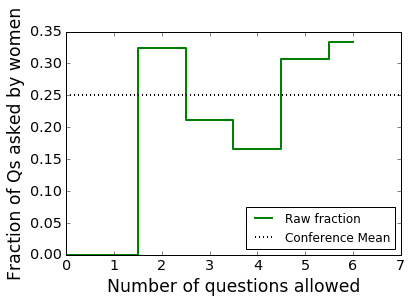

In [46]:
plot_fraction_allowed(cs19_count,conference_mean=0.25)

/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide


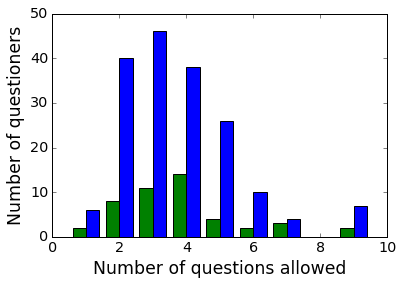

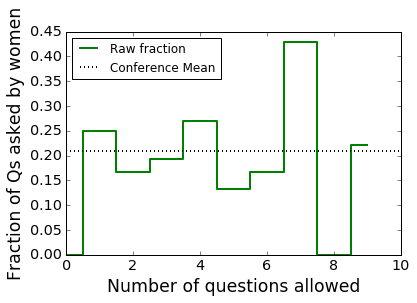

In [47]:
plot_fraction_allowed(cs18_count,conference_mean=0.21)

/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide


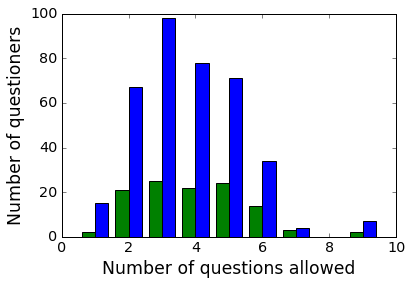

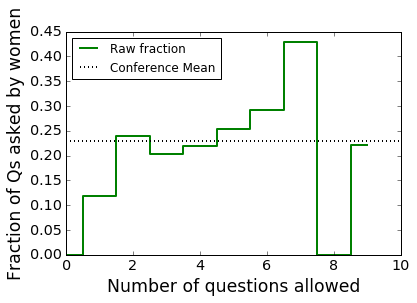

In [48]:
plot_fraction_allowed(combined_count,conference_mean=0.23)

I'm not sure how to interpret this, honestly. The two conferences have very different distributions.